In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect
import sys

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.10f' % x)

In [2]:
inputData = pd.read_csv('../data/rebuildPostingLatency.csv.gz', sep=';', compression='gzip')

In [3]:
inputData.describe()

,TermNo,DF,#Ones,PFD,Hyb,Hyb_Disk,Hyb_PFD,Hyb_Merge
count,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000,794518.0000000000
mean,531521.0601119169,7437.4889857750,4418.7816588170,0.0000326379,0.0000452144,0.0000192711,0.0000023798,0.0000235635
std,367906.3847269715,110959.9305186796,86465.7510926582,0.0002854447,0.0004558973,0.0001256243,0.0000121673,0.0003299287
min,0.0000000000,100.0000000000,1.0000000000,0.0000010000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,198853.2500000000,149.0000000000,18.0000000000,0.0000040000,0.0000030000,0.0000020000,0.0000010000,0.0000010000
50%,398313.5000000000,272.0000000000,47.0000000000,0.0000060000,0.0000050000,0.0000030000,0.0000010000,0.0000010000
75%,905429.7500000000,776.0000000000,150.0000000000,0.0000120000,0.0000120000,0.0000080000,0.0000020000,0.0000030000
max,1107204.0000000000,13059642.0000000000,11398025.0000000000,0.0474760000,0.0491210000,0.0094640000,0.0008510000,0.0389810000


(0, 0.0001)

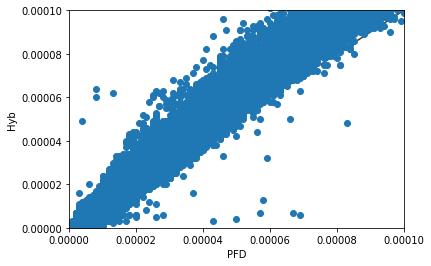

In [4]:
figure, ax = plt.subplots()

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.scatter(inputData['PFD'], inputData['Hyb'])
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_xlabel('PFD')
ax.set_ylabel('Hyb')
ax.set_xlim((0,0.0001))
ax.set_ylim((0,0.0001))

In [5]:
inputData['onesRatio'] = ((inputData['#Ones'] / inputData['DF']) * 100).round().astype("uint32")
inputData['winLoseRatio'] = inputData['Hyb'] / inputData['PFD']
print inputData["winLoseRatio"].mean()

0.932964987184


In [6]:
print inputData.columns

Index([u'TermNo', u'DF', u'#Ones', u'PFD', u'Hyb', u'Hyb_Disk', u'Hyb_PFD',
       u'Hyb_Merge', u'onesRatio', u'winLoseRatio'],
      dtype='object')


In [7]:
# Por longitud de Lista, organizada en bins, análisis ganancia-perdida (Tabla) #

# Max Postings List Lenght: 13,059,642 #
# [0,10^3), [10^3,10^4), [10^4,10^5), [10^5,10^6), [10^6,10^7), [10^7,10^8) #
logBins = np.logspace(3.0, 8, num=6, dtype=np.uint64)
proportionBins = np.arange(10, 100, 10)
binCount_winLoseRatio_per_Li = np.zeros(6, dtype=np.uint64)
binCount_winLoseRatio_per_OnesRatio = np.zeros((6, 10), dtype=np.uint64)
mean_winLoseRatio_perLi = np.zeros(6, dtype=np.float64)
mean_winLoseRatio_per_OnesRatio = np.zeros((6, 10), dtype=np.float64)
winLoseRatio_for_boxPlot= [[] for bin in logBins]

# Interval Type [) #
for row in inputData.values:
    Li_Len = row[1] # Longitud de la Lista (# de entradas - DF)
    indexLi = bisect.bisect_right(logBins, Li_Len)
    binCount_winLoseRatio_per_Li[indexLi] += 1
    mean_winLoseRatio_perLi[indexLi] += row[9]
    winLoseRatio_for_boxPlot[indexLi].append(row[9])
    indexOnesRatio = bisect.bisect_right(proportionBins, row[8])
    binCount_winLoseRatio_per_OnesRatio[indexLi, indexOnesRatio] += 1
    mean_winLoseRatio_per_OnesRatio[indexLi, indexOnesRatio] += row[9]

print mean_winLoseRatio_perLi.sum() / inputData.shape[0]
mean_winLoseRatio_perLi = mean_winLoseRatio_perLi / binCount_winLoseRatio_per_Li
assert inputData.shape[0] == binCount_winLoseRatio_per_Li.sum()
print mean_winLoseRatio_perLi

0.932964987184
[ 0.86170962  1.15508513  1.33563232  1.51657264  1.59675765  1.44181954]


In [11]:
#np.seterr(invalid='ignore')
for i, row in enumerate(mean_winLoseRatio_per_OnesRatio):
    mean_winLoseRatio_per_OnesRatio[i] = np.nan_to_num(np.divide(row, binCount_winLoseRatio_per_OnesRatio[i]))

/Users/earissola/virtualenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [12]:
#Posting List Max Lenght
print "PLML Mean Win/Lose(Row)\t 10%\t20%\t30%\t40%\t50%\t60%\t70%\t80%\t90%"
for i, mean in enumerate(mean_winLoseRatio_perLi):
    sys.stdout.write("%i %.10f " % (mean_winLoseRatio_perLi[i], mean))
    for mean_row in mean_winLoseRatio_per_OnesRatio[i]:
        sys.stdout.write(" %.3f " % (mean_row))
    sys.stdout.write("\n")
#Ganacia/Perdida 

PLML Mean Win/Lose(Row)	 10%	20%	30%	40%	50%	60%	70%	80%	90%
0 0.8617096193  0.879  0.904  0.911  0.849  0.808  0.755  0.694  0.628  0.530  0.420 
1 1.1550851339  1.165  1.146  1.158  1.233  1.261  1.170  1.134  1.098  1.008  0.846 
1 1.3356323154  1.306  1.304  1.340  1.363  1.373  1.368  1.333  1.340  1.311  1.297 
1 1.5165726423  2.300  1.423  1.496  1.541  1.577  1.561  1.529  1.496  1.475  1.446 
1 1.5967576513  0.000  0.000  0.000  1.809  1.773  1.726  1.662  1.579  1.469  1.313 
1 1.4418195415  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  1.455  1.429 


{'boxes': [<matplotlib.lines.Line2D at 0x1128e86d0>],
 'caps': [<matplotlib.lines.Line2D at 0x1128ce610>,
 'fliers': [<matplotlib.lines.Line2D at 0x1128db910>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1128db2d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1128e8890>,
  <matplotlib.lines.Line2D at 0x1128e8f90>]}

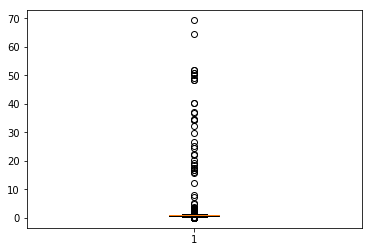

In [34]:
data = []
data.append(np.array(inputData[inputData['DF'] < logBins[0]]['winLoseRatio']))
#data.append(np.array(inputData[(inputData['DF'] < logBins[1] && inputData[inputData['DF'] >= logBins[0]])]['winLoseRatio']))
#data.append(np.array(inputData[inputData['DF'] < logBins[2]]['winLoseRatio']))
#data.append(np.array(inputData[inputData['DF'] < logBins[3]]['winLoseRatio']))
#data.append(np.array(inputData[inputData['DF'] < logBins[4]]['winLoseRatio']))
#data.append(np.array(inputData[inputData['DF'] < logBins[5]]['winLoseRatio']))

figure, ax = plt.subplots()
ax.boxplot(data)
